In [75]:
import os
import torch
import numpy as np 
import torchvision
import pandas as pd
from PIL import Image
import torch.nn as nn
from torchviz import make_dot
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [76]:
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [77]:
lr = 0.001
epochs = 1000
img_size = 128
down_sample_img_size = 32
train_batch_size = 16
valid_batch_size = 1
cover_loss_weight = 1
secret_loss_weight = 1
decoder_weight_loss = 1
dataset_path = "./new_data"

In [78]:
transforms = torchvision.transforms.ToTensor()

In [79]:
class StegDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_csv, transforms):
        self.dataset = pd.read_csv(dataset_csv)
        self.dataset = self.dataset.reset_index(drop=True)            
        self.transforms = transforms
        self.folder_type = "training" if "train" in dataset_csv else "validation"
    
    def __getitem__(self, index):
        cover_image = self.dataset.iloc[index]["cover_image"]
        secret_image = self.dataset.iloc[index]["secret_image"]

        cover_image = Image.open(os.path.join(dataset_path, self.folder_type, cover_image))
        secret_image = Image.open(os.path.join(dataset_path, self.folder_type, secret_image))

        transformed_cover_image = self.transforms(cover_image)
        transformed_secret_image = self.transforms(secret_image)
        
        return {
            "cover_image": transformed_cover_image,
            "secret_image": transformed_secret_image
        }
    
    def __len__(self):
        return len(self.dataset)

In [80]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        
        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=(3, 3), stride=stride, padding=1, groups=in_channels),
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )
        
        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [81]:
class MultiDepthwiseBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, stride):
        super().__init__()
        layers = []
        
        layers.append(DepthwiseSeparableConv(in_channels, out_channels, stride=stride))
        for _ in range(num_blocks-1):
            layers.append(DepthwiseSeparableConv(out_channels, out_channels, stride=1))
            
        self.sequential_layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.sequential_layers(x)

In [82]:
class PrepNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),

            MultiDepthwiseBlock(32, 32, 3, 1),
            MultiDepthwiseBlock(32, 64, 1, 1),
            
            MultiDepthwiseBlock(64, 64, 3, 2),
            MultiDepthwiseBlock(64, 128, 1, 1),

            MultiDepthwiseBlock(128, 128, 3, 2),
            MultiDepthwiseBlock(128, 256, 1, 1),

            MultiDepthwiseBlock(256, 256, 3, 1),
            MultiDepthwiseBlock(256, 150, 1, 1) 
        )

    def forward(self, secret_image):
        print("prep input", secret_image.shape)
        x = self.conv_layers(secret_image)
        print("prep output", x.shape)
        return x

In [83]:
class HidingNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=153, out_channels=32, kernel_size=(3, 3), stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),

            MultiDepthwiseBlock(32, 32, 3, 1),
            MultiDepthwiseBlock(32, 64, 1, 1),
            
            MultiDepthwiseBlock(64, 64, 3, 1),
            MultiDepthwiseBlock(64, 128, 1, 1),

            MultiDepthwiseBlock(128, 128, 3, 1),
            MultiDepthwiseBlock(128, 256, 1, 1),
        )

        self.up_sampler = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, secret_image, cover_image):
        print("secret image input", secret_image.shape)
        print("cover image before input", cover_image.shape)
        cover_image = F.interpolate(cover_image, size=(secret_image.shape[2], secret_image.shape[3]), mode="bilinear", align_corners=False)
        print("cover image input after interpolation", cover_image.shape)
        concatenated_image = torch.cat([secret_image, cover_image], dim=1)
        print("concatenated image before conv layer", concatenated_image.shape)
        x = self.conv_layers(concatenated_image)
        print("conv layer (hiding) input", x.shape)
        x = self.up_sampler(x)
        print("image after up sampler", x.shape)
        return x

In [84]:
class RevealNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),

            MultiDepthwiseBlock(32, 32, 3, 1),
            MultiDepthwiseBlock(32, 64, 1, 1),
            
            MultiDepthwiseBlock(64, 64, 3, 2),
            MultiDepthwiseBlock(64, 128, 1, 1),

            MultiDepthwiseBlock(128, 128, 3, 2),
            MultiDepthwiseBlock(128, 256, 1, 1),
        )

        self.up_sampler = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, stego_image):
        print("reveal net stego imge input", stego_image.shape)
        x = self.conv_layers(stego_image)
        print("reveal net after conv layer", x.shape)
        x = self.up_sampler(x)
        print("reaveal net afeter up sampler", x.shape)
        return x

In [85]:
class EncoderModel(nn.Module):
    def __init__(self, prepNet, hidingNet):
        super().__init__()
        self.prepNet = prepNet
        self.hidingNet = hidingNet
    
    def forward(self, cover_image, secret_image):
        encoded_image = self.prepNet(secret_image)
        stego_image = self.hidingNet(encoded_image, cover_image)
        return stego_image

In [86]:
class DecoderModel(nn.Module):
    def __init__(self, revealNet):
        super().__init__()
        self.revealNet = revealNet
    
    def forward(self, stego_image):
        predicted_secret_image = self.revealNet(stego_image)
        return predicted_secret_image

In [87]:
class EncoderLoss(nn.Module):
    def __init__(self, cover_weight, secret_weight):
        super().__init__()
        self.cover_weight = cover_weight
        self.secret_weight = secret_weight
        
    def forward(self, cover_image, predicted_cover_image, secret_image, predicted_secret_image):
        cover_loss = self.cover_weight * F.mse_loss(cover_image, predicted_cover_image)
        secret_loss = self.secret_weight * F.mse_loss(secret_image, predicted_secret_image) 
        return cover_loss + secret_loss

In [88]:
class DecoderLoss(nn.Module):
    def __init__(self, decoder_loss_weight):
        super().__init__()
        self.decoder_loss_weight = decoder_loss_weight
    
    def forward(self, predicted_secret_image, secret_image):
        reveal_img = self.decoder_loss_weight * F.mse_loss(secret_image, predicted_secret_image)
        return reveal_img

In [90]:
prep_net = PrepNet()
hiding_net = HidingNet()
reveal_net = RevealNet()

encoder_model = EncoderModel(prep_net, hiding_net)
decoder_model = DecoderModel(reveal_net)

encoder_model.to(device), decoder_model.to(device)

(EncoderModel(
   (prepNet): PrepNet(
     (conv_layers): Sequential(
       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
       (3): MultiDepthwiseBlock(
         (sequential_layers): Sequential(
           (0): DepthwiseSeparableConv(
             (depthwise): Sequential(
               (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
               (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
               (2): ReLU()
             )
             (pointwise): Sequential(
               (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
               (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
               (2): ReLU()
             )
           )
           (1): DepthwiseSeparableConv(
             (depthwise): Sequential(
         

In [91]:
training_csv_path = os.path.join(dataset_path, "train_dataset.csv")
validation_csv_path = os.path.join(dataset_path, "validation_dataset.csv")

training_dataset = StegDataset(training_csv_path, transforms)
valid_dataset = StegDataset(validation_csv_path, transforms)

train_data_loader = torch.utils.data.DataLoader(training_dataset, 
                                                batch_size=train_batch_size, 
                                                shuffle=True,
                                                drop_last=True,
                                                num_workers=0
                                               )

valid_data_loader = torch.utils.data.DataLoader(valid_dataset, 
                                                batch_size=valid_batch_size, 
                                                shuffle=True,
                                                drop_last=True,
                                                num_workers=0
                                               )

In [92]:
encoder_loss_func = EncoderLoss(cover_loss_weight, secret_loss_weight)
decoder_loss_func = DecoderLoss(decoder_weight_loss)

encoder_optimizer = torch.optim.Adam(encoder_model.parameters(), lr=lr)
decoder_optimizer = torch.optim.Adam(decoder_model.parameters(), lr=lr)

In [93]:
def training(encoder_model,
             decoder_model,
             encoder_loss_func, 
             decoder_loss_func,
             encoder_optimizer,
             decoder_optimizer,
             train_loader, 
             epochs,
             print_every=50):
    
    encoder_loss_list = []
    decoder_loss_list = []

    for epoch in range(epochs):
        for batch in train_loader:
            cover_image = batch["cover_image"].to(device)
            secret_image = batch["secret_image"].to(device)

            # Phase 1: Train encoder
            for param in encoder_model.parameters():
                param.requires_grad = True
            for param in decoder_model.parameters():
                param.requires_grad = False
                
            stego_image = encoder_model(cover_image, secret_image)  
            predicted_secret_image = decoder_model(stego_image)
            
            encoder_loss = encoder_loss_func(cover_image, stego_image, secret_image, predicted_secret_image)
            encoder_optimizer.zero_grad()
            encoder_loss.backward()
            encoder_optimizer.step()

            # Phase 2: Train Decoder
            for param in encoder_model.parameters():
                param.requires_grad = False
            for param in decoder_model.parameters():
                param.requires_grad = True

            with torch.no_grad():
                stego_image = encoder_model(cover_image, secret_image)

            predicted_secret_image = decoder_model(stego_image)
            decoder_loss = decoder_loss_func(predicted_secret_image, secret_image)
            decoder_optimizer.zero_grad()
            decoder_loss.backward()
            decoder_optimizer.step()
        
        encoder_loss_list.append(encoder_loss.item())
        decoder_loss_list.append(decoder_loss.item())
        
        # if epoch % print_every == 0:
        print("encoder loss {} | decoder loss {}".format(encoder_loss.item(), decoder_loss.item()))
        
    return encoder_model, decoder_model, encoder_loss_list, decoder_loss_list

In [94]:
enc_model, dec_model, enc_loss_list, dec_loss_list = training(encoder_model, 
                                                              decoder_model,
                                                              encoder_loss_func,
                                                              decoder_loss_func,
                                                              encoder_optimizer,
                                                              decoder_optimizer,
                                                              train_data_loader, 
                                                              1,
                                                              50)

prep input torch.Size([16, 3, 128, 128])
prep output torch.Size([16, 150, 32, 32])
secret image input torch.Size([16, 150, 32, 32])
cover image before input torch.Size([16, 3, 128, 128])
cover image input after interpolation torch.Size([16, 3, 32, 32])
concatenated image before conv layer torch.Size([16, 153, 32, 32])
conv layer (hiding) input torch.Size([16, 256, 32, 32])
image after up sampler torch.Size([16, 3, 128, 128])
reveal net stego imge input torch.Size([16, 3, 128, 128])
reveal net after conv layer torch.Size([16, 256, 32, 32])
reaveal net afeter up sampler torch.Size([16, 3, 128, 128])
prep input torch.Size([16, 3, 128, 128])
prep output torch.Size([16, 150, 32, 32])
secret image input torch.Size([16, 150, 32, 32])
cover image before input torch.Size([16, 3, 128, 128])
cover image input after interpolation torch.Size([16, 3, 32, 32])
concatenated image before conv layer torch.Size([16, 153, 32, 32])
conv layer (hiding) input torch.Size([16, 256, 32, 32])
image after up samp

In [95]:
enc_loss_list

[0.15482541918754578]

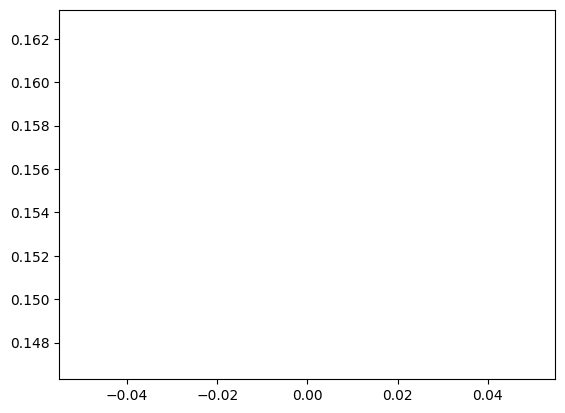

In [96]:
plt.plot(enc_loss_list)
plt.show()

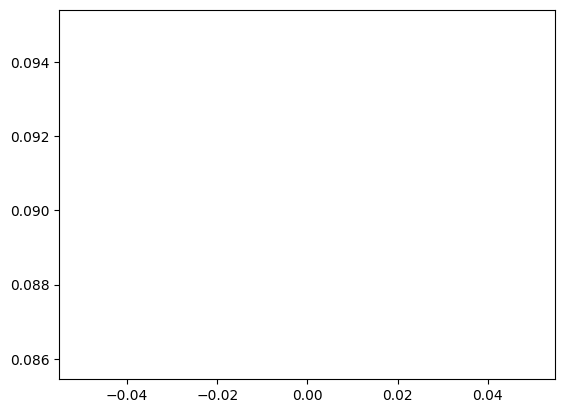

In [97]:
plt.plot(dec_loss_list)
plt.show()

In [81]:
# encoder_model.eval()
# decoder_model.eval()

In [89]:
# val_data = next(iter(valid_data_loader))
# cover_image = val_data.get("cover_image")
# secret_image = val_data.get("secret_image")

# with torch.no_grad():
#     stego_image = encoder_model(cover_image, secret_image)
#     predicted_secret_image = decoder_model(stego_image)

#     enc_loss = encoder_loss_func(predicted_secret_image, secret_image, stego_image, cover_image)
#     dec_loss = decoder_loss_funct(predicted_secret_image, secret_image)
    
#     print("encoder loss => ", enc_loss)
#     print("decoder loss => ", dec_loss)
    
#     plt.imshow(stego_image), plt.imshow(predicted_secret_image)